<a href="https://colab.research.google.com/github/LimYooyeol/AI-Paper-Code/blob/main/ViT/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/My Drive/Paper Implementation/'

%cd $BASE

%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Paper Implementation


'/content/drive/My Drive/Paper Implementation'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import os

In [18]:
!pip install einops

## Prepare Data (CIFAR 10)

### Load Data

In [19]:
DATAPATH = BASE + 'datasets'
if not os.path.exists(DATAPATH):
  os.mkdir(DATAPATH)

# set device
if torch.cuda.is_available() :
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])


# load data
train_data = dset.CIFAR10('./datasets', train = True, download = True, transform = transform)
loader_train = DataLoader(train_data, batch_size = 32, shuffle= True) # no validation set

test_data = dset.CIFAR10('./datasets', train = False, download = True, transform= transform)
loader_test = DataLoader(test_data, batch_size = 32, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


### show an image

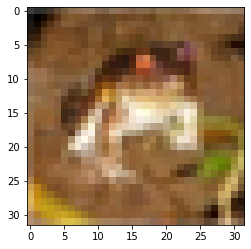

6


'frog'

In [20]:
import matplotlib.pyplot as plt

_, label = train_data[0]
img = train_data.data[0]

plt.imshow(img)
plt.show()
print(label)
train_data.classes[label]

## Define Training Loop

Referenced a lot from cs231n/assignment2 a lot for this part
( https://cs231n.github.io/assignments2021/assignment2/)

### Accuracy

In [21]:
def check_accuracy(data_loader, model, verbose = True) :

  if verbose :
    if data_loader.dataset.train :
      print('Train set accurcy')
    else :
      print('Test set accuracy')

  num_correct = 0
  num_total = 0
  model.eval() # evaluation mode

  with torch.no_grad() :
    for x, y in data_loader :
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)

      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_total += preds.size(0)
    
    acc = float(num_correct) / num_total
    if verbose :
      print('Correct : (%d / %d), Accuracy : (%.2f)' % (num_correct, num_total, 100*acc))

  return 100*acc

### Trainig Loop

In [22]:
def train(model, optimizer, data_loader, epochs = 1, verbose = True):
  model = model.to(device = device)

  log = {'loss' : [], 'acc' : []}

  for e in range(epochs):
    if verbose : 
      print('epochs : %d / %d' % (e, epochs))
    log['acc'].append(check_accuracy(loader_test, model, verbose = verbose))
    
    for t, (x, y) in enumerate(data_loader) :
      model.train() # training mode
      x = x.to(device = device)
      y = y.to(device = device)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % 100 == 0 :
        log['loss'].append(loss)
        if verbose :
          print('iteration %d, loss = %.4f' % (t, loss.item()))
  
  return log

## Modules

### Embedding

In [23]:
from einops import rearrange

class Embedding(nn.Module) :
  def __init__(self, input_size = 32, input_channel = 3, hidden_size = 8*8*3, patch_size = 4) :
    super().__init__()

    self.patch_size = patch_size
    self.hidden_size = hidden_size

    self.projection = nn.Linear((patch_size**2)*input_channel, hidden_size, bias = False)

    self.cls_token = nn.Parameter(torch.zeros(hidden_size), requires_grad= True)

    num_patches = int((input_size / patch_size) ** 2 + 1)

    self.positional = nn.Parameter(torch.zeros((num_patches, hidden_size), requires_grad= True))


  def forward(self, x) :
    x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1 = self.patch_size, p2 = self.patch_size)
    x = self.projection(x)

    batch_size = x.shape[0]

    x = torch.concat((self.cls_token.expand(batch_size, 1, self.hidden_size), x), axis = 1)

    x = x + self.positional

    return x


In [24]:
temp = torch.arange(32*3*32*32, dtype = torch.float32).reshape(32, 3, 32, 32)
emb = Embedding()
emb(temp).shape

torch.Size([32, 65, 192])

### Transformer Encoder

#### -MSA

In [25]:
# not parallelized version
"""
class SelfAttention(nn.Module) :
  def __init__(self, input_dim, D_h) :
    super().__init__()

    self.D_h = D_h

    self.q = nn.Linear(input_dim, D_h, bias = False)
    self.k = nn.Linear(input_dim, D_h, bias = False)
    self.v = nn.Linear(input_dim, D_h, bias = False)

    self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    k_tranpose = torch.transpose(k, 1, 2)
    v = self.v(x)

    A = self.softmax(torch.matmul(q, k_tranpose) / (self.D_h ** (1/2)))

    return torch.matmul(A, v)

class MSA(nn.Module) :
  def __init__(self, hidden_dim = 192, num_heads = 6) :
    super().__init__()

    self.num_heads = num_heads

    heads = []
    for i in range(0, num_heads) :
      heads.append(SelfAttention(input_dim = hidden_dim, D_h = int(hidden_dim / num_heads)))

    self.heads = nn.ModuleList(heads)    

  def forward(self, x):
    score = []

    for i in range(0, self.num_heads) : 
      score.append(self.heads[i](x))
    
    return torch.concat(score, axis = 2)
"""

'\nclass SelfAttention(nn.Module) :\n  def __init__(self, input_dim, D_h) :\n    super().__init__()\n\n    self.D_h = D_h\n\n    self.q = nn.Linear(input_dim, D_h, bias = False)\n    self.k = nn.Linear(input_dim, D_h, bias = False)\n    self.v = nn.Linear(input_dim, D_h, bias = False)\n\n    self.softmax = nn.Softmax(dim = 1)\n\n  def forward(self, x):\n    q = self.q(x)\n    k = self.k(x)\n    k_tranpose = torch.transpose(k, 1, 2)\n    v = self.v(x)\n\n    A = self.softmax(torch.matmul(q, k_tranpose) / (self.D_h ** (1/2)))\n\n    return torch.matmul(A, v)\n\nclass MSA(nn.Module) :\n  def __init__(self, hidden_dim = 192, num_heads = 6) :\n    super().__init__()\n\n    self.num_heads = num_heads\n\n    heads = []\n    for i in range(0, num_heads) :\n      heads.append(SelfAttention(input_dim = hidden_dim, D_h = int(hidden_dim / num_heads)))\n\n    self.heads = nn.ModuleList(heads)    \n\n  def forward(self, x):\n    score = []\n\n    for i in range(0, self.num_heads) : \n      score.app

In [26]:
# https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/transfomer.md

class MSA(nn.Module) :
  def __init__(self, hidden_dim = 8*8*3, num_heads = 6) :
    super().__init__()

    self.num_heads = num_heads
    self.D_h = (hidden_dim / num_heads) ** (1/2) 

    self.queries = nn.Linear(hidden_dim, hidden_dim)
    self.keys = nn.Linear(hidden_dim, hidden_dim)
    self.values = nn.Linear(hidden_dim, hidden_dim)

    self.softmax = nn.Softmax(dim = 1)


  def forward(self, x) :
    q = rearrange(self.queries(x), 'b n (h d) -> b h n d', h = self.num_heads)
    k = rearrange(self.queries(x), 'b n (h d) -> b h n d', h = self.num_heads)
    v = rearrange(self.queries(x), 'b n (h d) -> b h n d', h = self.num_heads)

    A = torch.einsum('bhqd, bhkd -> bhqk', q, k)
    A = self.softmax(A / self.D_h)

    Ax = torch.einsum('bhan, bhnd -> bhad' ,A, v) # b : batch size, h : num_heads, n : num_patches, a : num_patches, d : D_h
    return rearrange(Ax, 'b h n d -> b n (h d)')

In [27]:
temp = torch.zeros(32, 65, 192)

MSA()(temp).shape

torch.Size([32, 65, 192])

#### -MLP

In [28]:
class MLP(nn.Module):
  def __init__(self, input_dim = 8*8*3, hidden_dim = 8*8*3*4, output_dim = 8*8*3):
    super().__init__()

    self.feedforward = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.GELU(),
        nn.Linear(hidden_dim, output_dim),
        nn.GELU()
    )

  def forward(self, x) :
    return self.feedforward(x)

In [29]:
temp = torch.zeros(32, 65, 192)
MLP()(temp).shape

torch.Size([32, 65, 192])

#### -Transformer Encoder

In [30]:
class TransformerEncoderBlock(nn.Module) :
  def __init__(self, hidden_dim = 8*8*3, num_heads = 6, mlp_size = 8*8*3*4):
    super().__init__()

    self.LN = nn.LayerNorm(normalized_shape= hidden_dim)
    self.MSA = MSA(hidden_dim = hidden_dim, num_heads = num_heads)
    self.MLP = MLP(input_dim = hidden_dim, hidden_dim = mlp_size, output_dim = hidden_dim)

  def forward(self, x) :
    x_prev = x
    x = self.LN(x)
    x = self.MSA(x)

    x = x + x_prev
    x_prev = x

    x = self.LN(x)
    x = self.MLP(x)

    return x + x_prev

In [31]:
temp = torch.zeros(32, 65, 192)
TransformerEncoderBlock()(temp).shape

torch.Size([32, 65, 192])

In [32]:
class TransformerEncoder(nn.Module):
  def __init__(self, hidden_dim = 8*8*3, num_layers = 8) :
    super().__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    layers = []

    for i in range(0, num_layers) :
      layers.append(TransformerEncoderBlock())

    self.blocks = nn.ModuleList(layers)

    self.LN = nn.LayerNorm(normalized_shape= hidden_dim)

  def forward(self, x):
    for i in range(0, self.num_layers) :
      x = self.blocks[i](x)

    return self.LN(x[:, 0, :])

In [33]:
temp = torch.zeros(32, 65, 192)
TransformerEncoder()(temp).shape

torch.Size([32, 192])

### MLPHead

In [34]:
class MLPHead(nn.Module) :
  def __init__(self, input_dim = 8*8*3, hidden_dim = 8*8*3*4, num_classes = 10) :
    super().__init__()

    self.feedforward = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, x) :
    return self.feedforward(x)

In [35]:
temp = torch.zeros(32, 192)
MLPHead()(temp).shape

torch.Size([32, 10])

### ViT

In [36]:
class ViT(nn.Module) :
  def __init__(self, input_size = 32, patch_size = 4, hidden_size = 8*8*3, num_layers = 8) :
    super().__init__()

    self.vit = nn.Sequential(
        Embedding(input_size = input_size, input_channel = 3, hidden_size = hidden_size, patch_size = patch_size),
        TransformerEncoder(hidden_dim = hidden_size, num_layers = num_layers),
        MLPHead(input_dim = hidden_size, hidden_dim = hidden_size*4, num_classes= 10)
    )

  def forward(self, x):
    return self.vit(x)


In [37]:
temp = torch.zeros(32, 3, 32, 32).to(device= device)
ViT().to(device = device)(temp).shape

torch.Size([32, 10])

## Training

In [ ]:
learning_rate = 1e-3

vit = ViT()
optimizer = optim.Adam(vit.parameters(), lr = learning_rate, betas = (0.9, 0.99))

In [ ]:
training_log = train(vit, optimizer, loader_train, epochs = 20, verbose = False)

In [ ]:
def plot_loss(loss, label) :
  plt.xlabel('iterations(1e2)')
  plt.ylabel('training loss')

  plt.plot(loss, label = label)
  plt.legend()

def plot_acc(acc, label) :
  plt.xlabel('epochs')
  plt.ylabel('accuracy(test data)')

  plt.plot(acc, label = label)
  plt.legend()

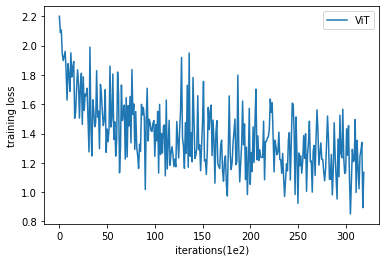

In [ ]:
plot_loss(training_log['loss'], 'ViT')

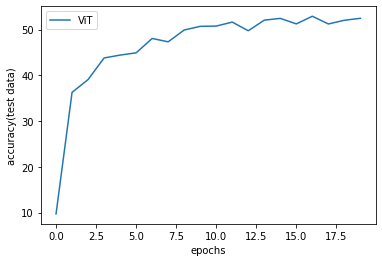

In [ ]:
plot_acc(training_log['acc'], 'ViT')